# **ch.04 다양한 분류 알고리즘**
## 04-1 로지스틱 회귀
### 풀어야 할 문제:
> ### 럭키백에 들어있는 생선의 length, weight, height, width, diagonal가 주어졌을 때, 7가지 생선 중 어떤 생선인지에 대한 확률 구하기
### *데이터 준비하기*   
pandas read_csv() function으로 data 준비

In [1]:
import pandas as pd

fish = pd.read_csv('https://bit.ly/fish_csv_data')

fish.head()

,Species,Weight,Length,Diagonal,Height,Width
0,Bream,242.0,25.4,30.0,11.5200,4.0200
1,Bream,290.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,26.5,31.1,12.3778,4.6961
3,Bream,363.0,29.0,33.5,12.7300,4.4555
4,Bream,430.0,29.0,34.0,12.4440,5.1340


어떤 종류의 생선이 있는지 unique() function을 사용하여 Species column에서 고유한 값 추출

In [2]:
pd.unique(fish['Species'])

array(['Bream', 'Roach', 'Whitefish', 'Parkki', 'Perch', 'Pike', 'Smelt'],
      dtype=object)

fish dataframe에서 Species column은 target data, 나머지 5개 column은 input data로 사용

In [3]:
fish_target = fish['Species'].to_numpy()
fish_input = fish[['Weight', 'Length', 'Diagonal', 'Height', 'Width']].to_numpy()

In [4]:
print(fish_input[:5])

[[242.      25.4     30.      11.52     4.02  ]
 [290.      26.3     31.2     12.48     4.3056]
 [340.      26.5     31.1     12.3778   4.6961]
 [363.      29.      33.5     12.73     4.4555]
 [430.      29.      34.      12.444    5.134 ]]


train set, test set으로 나누기

In [5]:
from sklearn.model_selection import train_test_split

train_input, test_input, train_target, test_target = train_test_split(fish_input, fish_target, random_state=42)

StandardScaler로 train set과 test set을 normalization  
이 때, train set의 statistic value로 test set을 변환해야 함

In [6]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
ss.fit(train_input)

train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)

### *k-최근접 이웃 분류기의 확률 예측*  
import KNeighborsClassifier,  
generate class object(n_neighbors=3),  
train model,  
score model

In [7]:
from sklearn.neighbors import KNeighborsClassifier

kn = KNeighborsClassifier(n_neighbors=3)

kn.fit(train_scaled, train_target)

print(kn.score(train_scaled, train_target))
print(kn.score(test_scaled, test_target))

0.8907563025210085
0.85


multi-class classification:  
target data에 2개 이상의 class가 포함된 문제  
binary classification과 model을 만들고 train하는 방식은 동일함


binary classification에서는 positive class와 negative class를 각각 1과 0으로 지정하여 target data를 만들었지만, multi-class classification의 경우 scikit-learn에서 letter class를 그대로 사용할 수 있음  
이 때, target을 그대로 model에 전달하면 순서가 자동으로 alphabet 순서로 매겨짐  
KNeighborsClassifier에서 정렬된 target은 classes_ attribute에 저장되어 있음

In [8]:
print(kn.classes_)

['Bream' 'Parkki' 'Perch' 'Pike' 'Roach' 'Smelt' 'Whitefish']


predict() method의 output도 letter target을 지원함  
test set의 처음 5개 sample에 대한 prediction

In [9]:
print(kn.predict(test_scaled[:5]))

['Perch' 'Smelt' 'Pike' 'Perch' 'Perch']


scikit-learn의 classification model은 predict_proba() method로 class별 probability value를 return함  
앞서 predict한 test set의 sample에 대한 probability 출력

In [10]:
import numpy as np

proba = kn.predict_proba(test_scaled[:5])

print(np.round(proba, decimals=4))

[[0.     0.     1.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     1.     0.    ]
 [0.     0.     0.     1.     0.     0.     0.    ]
 [0.     0.     0.6667 0.     0.3333 0.     0.    ]
 [0.     0.     0.6667 0.     0.3333 0.     0.    ]]


model이 계산한 probability가 가장 가까운 neighbor의 rate가 맞는지 4th sample의 neighbor를 통해 확인

In [11]:
distances, indexes = kn.kneighbors(test_scaled[3:4])

print(train_target[indexes])

[['Roach' 'Perch' 'Perch']]


앞서 출력한 predict_proba() method의 결과와 일치


그러나 이 model은 n_neighbors를 3으로 설정했기에 가능한 확률은 0/3, 1/3, 2/3, 3/3이 전부  
확률이라하기도 애매함


### *로지스틱 회귀*  
logistic regression:  
이름은 regression이지만, classification model임  
linear regression과 마찬가지로 linear equation(line)을 학습함



ex) $z = a\times(Weight) + b\times(Length) + c\times(Diagonal) + d\times(Height) + e\times(Width) + f$  
여기에서 $a, b, c, d, e$는 weight 혹은 coefficient  
feature는 늘어났지만 multiple regression을 위한 linear equation과 같은 형태  
$z$는 어떤 값도 가능하지만, 확률이 되려면 0~1 사이의 값을 가져야 함  
이를 위해 $z$가 negative일 때는 0이 되고, $z$가 1을 넘어서는 큰 positive가 될 때 1로 바꾸는 sigmoid function(or logistic function)을 사용


sigmoid function을 사용하면 $z$가 어떤 값이 되더라도 절대로 0~1 사이의 범위를 벗어날 수 없음 &rarr; 이 값을 확률로 해석할 수 있음

sigmoid function visualization (expotential 계산은 numpy exp() function 사용)

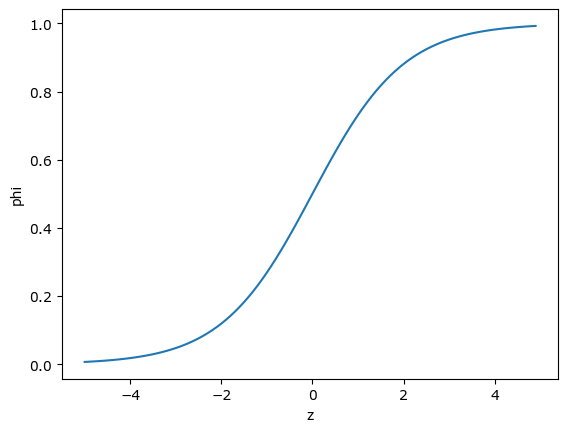

In [12]:
import numpy as np
import matplotlib.pyplot as plt

z = np.arange(-5, 5, 0.1)
phi = 1/(1+np.exp(-z))

plt.plot(z, phi)
plt.xlabel('z')
plt.ylabel('phi')
plt.show()

### *로지스틱 회귀로 이진 분류 수행하기*  
multi-class classification 수행 전, binary classification 수행해 보기  
binary classification의 경우,  
sigmoid의 output > 0.5: positive class,  
output < 0.5: negative class  
로 분류


bream과 smelt 2개 class를 사용하여 binary classfication 수행


boolean indexing: numpy array에서 Ture, False value를 전달하여 row를 선택

In [13]:
char_arr = np.array(['A', 'B', 'C', 'D', 'E'])
print(char_arr[[True, False, True, False, False]])

['A' 'C']


boolean indexing과 comparison operator을 활용하여 bream, smelt row만 골라내기

In [14]:
bream_smelt_indexes = (train_target=='Bream') | (train_target=='Smelt')

train_bream_smelt = train_scaled[bream_smelt_indexes]
target_bream_smelt = train_target[bream_smelt_indexes]

import LogisticRegression,  
generate class object,  
train model

In [15]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

lr.fit(train_bream_smelt, target_bream_smelt)

LogisticRegression()

train_bream_smelt에 있는 처음 5개 sample에 대하여 prediction

In [16]:
lr.predict(train_bream_smelt[:5])

array(['Bream', 'Smelt', 'Bream', 'Bream', 'Bream'], dtype=object)

call predict_proba() method, 해당 sample에 대한 probability 출력

In [17]:
lr.predict_proba(train_bream_smelt[:5])

array([[0.99759855, 0.00240145],
       [0.02735183, 0.97264817],
       [0.99486072, 0.00513928],
       [0.98584202, 0.01415798],
       [0.99767269, 0.00232731]])

위에서 출력된 2가지 probability는 positive, negative class에 대한 probability  
이 중, positive class는 classes_ attribute에 따라(alphabet 순서) Smelt

In [18]:
print(lr.classes_)

['Bream' 'Smelt']


logistic regression이 학습한 coefficient 확인

In [19]:
print(lr.coef_, lr.intercept_)

[[-0.4037798  -0.57620209 -0.66280298 -1.01290277 -0.73168947]] [-2.16155132]


$\therefore$ logistic regression이 학습한 equation은 다음과 같음  
$z = -0.404\times(Weight)  -0.576\times(Length) -0.663\times(Diagonal) - 1.013\times(Height) - 0.732\times(Width) - 2.161$


decision_function() method를 call하여 $z$ 출력

In [20]:
decisions = lr.decision_function(train_bream_smelt[:5])
print(decisions)

[-6.02927744  3.57123907 -5.26568906 -4.24321775 -6.0607117 ]


이 $z$ value를 sigmoid funciton에 입력하면 probability를 얻을 수 있음  
scipy의 sigmoid function인 expit() function을 사용하여 probability 확인

In [21]:
from scipy.special import expit

print(expit(decisions))

[0.00240145 0.97264817 0.00513928 0.01415798 0.00232731]


출력이 predict_proba()의 두 번째 cloumn과 동일  
$\therefore$ decision_funciton() method는 positive class에 대한 $z$ value를 return함


### *로지스틱 회귀로 다중 분류 수행하기* 
multi-class classification도 binary classification과 크게 다르지 않음


LogisticRegression class basically use iterative algorithm  
max_iter parameter를 통해 반복 횟수를 지정. 기본값인 100으로 지정하면 반복 횟수가 부족하다는 warning이 발생하므로, 여기에서는 1,000으로 지정


LogisticRegression class basically regulates squared values of coefficients, such as ridge regression (L2 regulation)  
In LogisticRegression, the parameter that controls the regulation is C  
The smaller C, the greater regulation. It is opposite of alpha which is a parameter of ridge and lasso that controls regulation.  
여기에서는 regulation을 완화하기 위해 20으로 지정


train LogisticRegression,  
score model

In [22]:
lr = LogisticRegression(C=20, max_iter=1000)

lr.fit(train_scaled, train_target)

print(lr.score(train_scaled, train_target))
print(lr.score(test_scaled, test_target))

0.9327731092436975
0.925


Print prediction for 5 samples of test set

In [23]:
print(lr.predict(test_scaled[:5]))

['Perch' 'Smelt' 'Pike' 'Roach' 'Perch']


Print probability of prediction for 5 samples of test set  
&rarr; 5 samples에 대한 prediction이므로 5 rows, 7 species에 대한 prediction이므로 7 columns

In [24]:
proba = lr.predict_proba(test_scaled[:5])

print(np.round(proba, decimals=3))

[[0.    0.014 0.841 0.    0.136 0.007 0.003]
 [0.    0.003 0.044 0.    0.007 0.946 0.   ]
 [0.    0.    0.034 0.935 0.015 0.016 0.   ]
 [0.011 0.034 0.306 0.007 0.567 0.    0.076]
 [0.    0.    0.904 0.002 0.089 0.002 0.001]]


mulit-class classification의 linear equation의 coefficient 확인  
&rarr; this data는 5 features를 사용하므로 coef_의 column 수는 5, multi-class classification은 class마다 $z$ value를 계산하므로 coef_의 row 수는 7

In [26]:
print(lr.coef_.shape, lr.intercept_.shape)

(7, 5) (7,)


binary classification에서 sigmoid function을 사용해 두 개 class의 $z$ vlaue를 probability로 변환했던 것처럼, multi-class classification에서는 softmax function을 사용하여 class 수 만큼의 $z$ vlaue를 probability로 변환


softmax function 확인을 위해 decision_function()으로 $z1$~$z7$까지 구하고, softmax에 전달하여 probability 확인  
softmax() function의 axis parameter를 1로 지정(각 row, 즉 각 sample에 대해 calculate)  
만약 axis를 지정하지 않으면, 전체 array에 대한 probability를 calculate

In [29]:
from scipy.special import softmax

decisions = lr.decision_function(test_scaled[:5])

proba = softmax(decisions, axis=1)

print(np.round(proba, decimals=3))

[[0.    0.014 0.841 0.    0.136 0.007 0.003]
 [0.    0.003 0.044 0.    0.007 0.946 0.   ]
 [0.    0.    0.034 0.935 0.015 0.016 0.   ]
 [0.011 0.034 0.306 0.007 0.567 0.    0.076]
 [0.    0.    0.904 0.002 0.089 0.002 0.001]]


앞서 구한 predict_proba()의 output과 같음